In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P
from mppi.Utilities import Tools
from mppi.Utilities import Constants as Const
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [3]:
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '
dest_path = 'GW_HF_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} -e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '/home/marco/Data/RICERCA/DFT AND MANY BODY/2D ELECTRONIC AND OPTICAL PROPERTIES/GERMANENE/GW_HF_analysis'


In [3]:
omp = 1
mpi = 16 #4
sbatch_options = ['--partition=all12h']

In [4]:
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo')
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo',scheduler='slurm',sbatch_options=sbatch_options)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'omp': 1,
 'mpi': 16,
 'mpi_run': 'mpirun -np',
 'executable': 'yambo',
 'scheduler': 'slurm',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'sbatch_options': ['--partition=all12h'],
 'activate_BeeOND': True,
 'verbose': True}

# GW convergence analysis of the Germanene

We compute the GW corrections of the DFT band structure of the Germanene. 

We discuss the convergene procedure using various approximations of the self-energy.

We have performed various preliminary tests in particular:

__Parallelization strategy__

We set the SE_ROLEs as 'b.qp.q' and we observe that (with 16 mpi)
* for 6,6,1 kpoints the highest performance are achieved with '16.1.1'
* for 12,12,1 kpoints the only working configuration is '16.1.1' (reasons are to be checked further...)

__Random integration method (RIM) and Coulomb potential cutoff__

.........

## Hartree-Fock convergence analysis 

At the Hartree-Fock (HF) level the self energy is limited to the exchange part $\Sigma_x$ written in term of the
bare Coulomb potential.

The diagonal matrix elements of $\Sigma_x$ on the KS states are written as
$$
\langle nk|\Sigma_x|nk \rangle = -\sum_{n'}\int_{BZ}dq\sum_G \frac{4\pi}{|q+G|^2}
|\rho_{nn'}(k,q,G|^2f_{n',k-q}
$$
The sum over $n'$ il limited to the full bands due the $f_{n'}$ factor and so the self energy in this
approximation scheme depends on the $k$-points sampling in the BZ (q sum) and on the cutoff of the plane wave
expansion of the KS states.

We study the converge of the direct gap at the $K$ point in function of the number of plane wave of the exchange (EXXRLvcs variable in Yambo).
The highest value of this variable is given by the cutoff of the density matrix in QuantumESPRESSO, that in turn is
4 times the cutoff on the KS wave functions ($90*4=360$ Ry in the present analysis).

We also study the convergence of the gap in function of the $k$-points sampling of the BZ.

In [5]:
test_set = {
    12:{'source_dir' : 'DFT_analysis/kpoints_12-nbnds_60.save', 
            'run_dir' :  'GW_HF_analysis/kpoints_12'},
    15:{'source_dir' : 'DFT_analysis/kpoints_15-nbnds_60.save', 
            'run_dir' :  'GW_HF_analysis/kpoints_15'},
    18:{'source_dir' : 'DFT_analysis/kpoints_18-nbnds_60.save', 
            'run_dir' :  'GW_HF_analysis/kpoints_18'}
}   

In [6]:
kp = 12

In [7]:
Tools.build_SAVE(test_set[kp]['source_dir'],test_set[kp]['run_dir'],command='p2y')

SAVE folder already present in GW_HF_analysis/kpoints_12. No operations performed.


We build the input for HF analysis including the random integration method (RIM) for the small $q$ component of the Coulomb potential
and the cutoff of the Coulomb potential in the off plane direction. The z dimension of the simulation box is 
$7.643*8 = 61.44$ au and we set the cutoff of the potential slightly smaller than this value.

In [8]:
cut_z = 60
RandQpts = 1000000 # Number of random q-points in the BZ
RandGvec = 100 # use the RIM for the first 100 G-components of the coulomb potential 

dft_data = P.PwParser(os.path.join(test_set[kp]['source_dir'],'data-file-schema.xml'))
K_value = len(dft_data.kpoints) # K is the last point in the k sampling
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections

EXXRLvcs = [20,40,60,80,100,200]

Parse file : DFT_analysis/kpoints_12-nbnds_60.save/data-file-schema.xml


In [9]:
inp = I.YamboInput(args='yambo -r -x -V all',folder=test_set[kp]['run_dir'])
inp.set_extendOut()
inp.set_kRange(K_value,K_value)
inp.set_bandRange(start_band,stop_band)
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['SE_CPU'] = '%s.1.1'%mpi
inp['variables']['SE_ROLEs'] = 'b.qp.q'
#inp

In [13]:
study = D.Dataset(run_dir=test_set[kp]['run_dir'],num_tasks=3,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

Initialize a Dataset with 3 parallel tasks


In [14]:
for ex in EXXRLvcs:
    idd = {'EXXRLvcs':ex,'cutz':cut_z}
    inp['variables']['EXXRLvcs'] = [ex,'Ry']
    study.append_run(id=idd,input=inp,runner=code)

In [15]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1, 2], [3, 4, 5]] 

Run the task [0, 1, 2] 
Skip the run of EXXRLvcs_20-cutz_60
Skip the run of EXXRLvcs_40-cutz_60
Skip the run of EXXRLvcs_60-cutz_60
Task [0, 1, 2] ended 
 
Run the task [3, 4, 5] 
Skip the run of EXXRLvcs_200-cutz_60
Skip the run of EXXRLvcs_100-cutz_60
Skip the run of EXXRLvcs_80-cutz_60
Task [3, 4, 5] ended 
 


In [16]:
test_set[kp]['data'] = results

Once that all computations are performed we plot the data to check convergence criteria

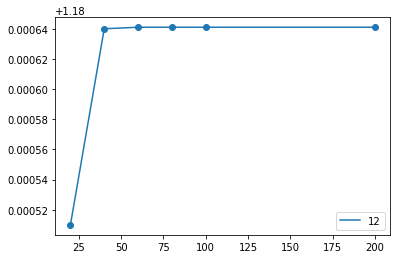

In [22]:
for kp in test_set:
    if 'data' in test_set[kp]:
        r = test_set[kp]['data']
        eng_gap = [r[ind].data.get_gap(k_full=K_value,band_full=start_band,verbose=False) for ind in range(len(EXXRLvcs))]
        plt.plot(EXXRLvcs,eng_gap,label=kp)
        plt.scatter(EXXRLvcs,eng_gap)
plt.legend()

In [ ]:
#########################################################################################################à

In [21]:
eng_val = [results[ind].data.get_energy(k=19,bnd=28,verbose=False) for ind in range(len(EXXRLvcs))]
eng_cond = [results[ind].data.get_energy(k=19,bnd=29,verbose=False) for ind in range(len(EXXRLvcs))]
eng_gap = [results[ind].data.get_gap(k_full=19,band_full=28,verbose=False) for ind in range(len(EXXRLvcs))]

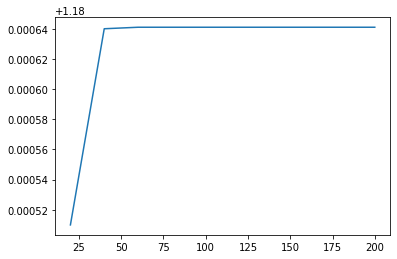

In [25]:
#plt.plot(EXXRLvcs,eng_val)
#plt.plot(EXXRLvcs,eng_cond)
plt.plot(EXXRLvcs,eng_gap)


In [15]:
results[0].data.get_gap(k_full=19,band_full=28)

Compute energy of the state k=19,b=28 for the hf runlevel.
Compute energy of the state k=19,b=29 for the hf runlevel.
(kpoint,band) indexes of the full state: (19, 28)
(kpoint,band) indexes of the empty state: (19, 29)
Energy gap = 1.18051 eV


1.18051

In [93]:
gap = [results[ind] for ind in range(len(EXXRLvcs))]
gap

[1.18051, 1.1806400000000001, 1.180641, 1.180641, 1.180641, 1.180641]

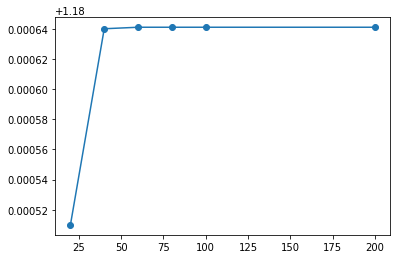

In [92]:
plt.plot(EXXRLvcs,gap)
plt.scatter(EXXRLvcs,gap)

Seeking convergence for id " {'EXXRLvcs': 20, 'cutz': 60} "
Convergence reached in Dataset "Dataset" for id " {'EXXRLvcs': 20, 'cutz': 60} "


/home/marco/Applications/MPPI/mppi/Datasets/Dataset.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.tick_params(axis='both', which='major', labelsize=14)


{'id_conv': {'EXXRLvcs': 20, 'cutz': 60}, 'value_conv': 1.18051}

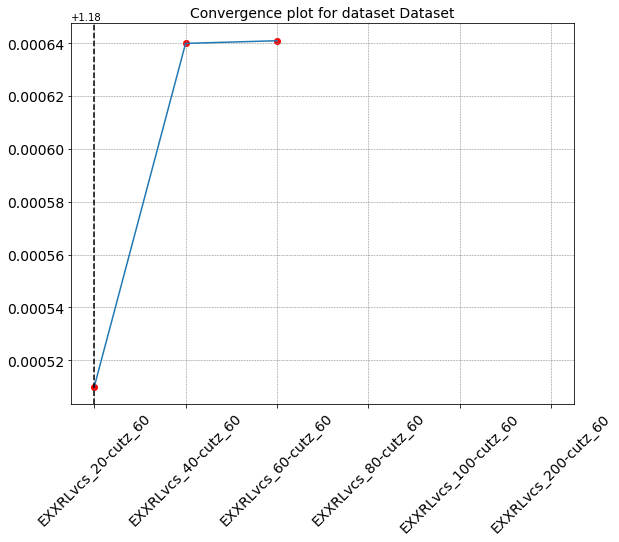

In [86]:
study.update_global_options(verbose=False)
study.seek_convergence(rtol=1e-3,convergence_level=2)